In [1]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

# Invoke a primitive. For more details see https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials.html
# result = Sampler("ibmq_qasm_simulator").run(circuits).result()

In [2]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.25.1', 'qiskit': '0.44.1', 'qiskit-aer': '0.12.2', 'qiskit-ignis': None, 'qiskit-ibmq-provider': '0.20.2', 'qiskit-nature': '0.6.2', 'qiskit-finance': None, 'qiskit-optimization': '0.5.0', 'qiskit-machine-learning': '0.6.1'}

In [3]:
# useful additional packages 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# importing Qiskit
from qiskit import BasicAer, IBMQ
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.compiler import transpile
from qiskit.tools.monitor import job_monitor

# import basic plot tools
from qiskit.tools.visualization import plot_histogram

In [4]:
# Load our saved IBMQ accounts
IBMQ.load_account()

/tmp/ipykernel_218/1036386158.py:2: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  IBMQ.load_account()


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [5]:
n = 13 # the length of the first register for querying the oracle 

In [6]:
# Choose a type of oracle at random. With probability half it is constant, 
# and with the same probability it is balanced
oracleType, oracleValue = np.random.randint(2), np.random.randint(2)

if oracleType == 0:
    print("The oracle returns a constant value ", oracleValue)
else:
    print("The oracle returns a balanced function")
    a = np.random.randint(1,2**n) # this is a hidden parameter for balanced oracle. 

# Creating registers
# n qubits for querying the oracle and one qubit for storing the answer
qr = QuantumRegister(n+1) #all qubits are initialized to zero
# for recording the measurement on the first register
cr = ClassicalRegister(n)

circuitName = "DeutschJozsa"
djCircuit = QuantumCircuit(qr, cr)

# Create the superposition of all input queries in the first register by applying the Hadamard gate to each qubit.
for i in range(n):
    djCircuit.h(qr[i])

# Flip the second register and apply the Hadamard gate.
djCircuit.x(qr[n])
djCircuit.h(qr[n])
    
# Apply barrier to mark the beginning of the oracle
djCircuit.barrier()

if oracleType == 0:#If the oracleType is "0", the oracle returns oracleValue for all input. 
    if oracleValue == 1:
        djCircuit.x(qr[n])
    else:
        djCircuit.iden(qr[n])
else: # Otherwise, it returns the inner product of the input with a (non-zero bitstring) 
    for i in range(n):
        if (a & (1 << i)):
            djCircuit.cx(qr[i], qr[n])
        
# Apply barrier to mark the end of the oracle
djCircuit.barrier()

# Apply Hadamard gates after querying the oracle
for i in range(n):
    djCircuit.h(qr[i])
    
# Measurement
djCircuit.barrier()
for i in range(n):
    djCircuit.measure(qr[i], cr[i])

The oracle returns a constant value  1


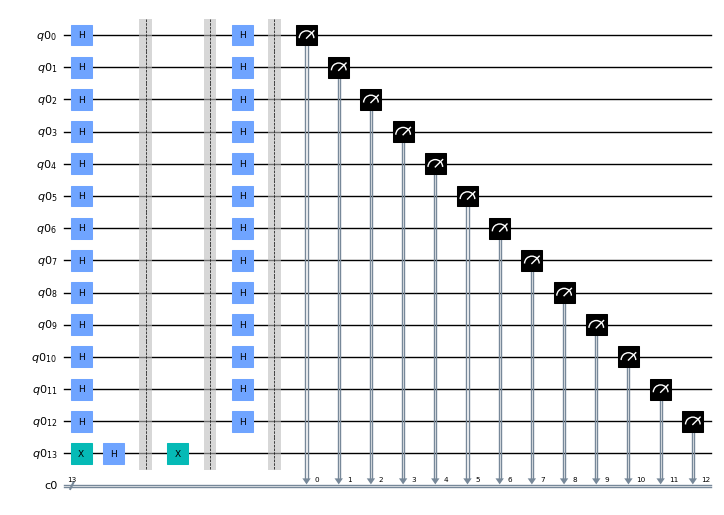

In [7]:
#draw the circuit
djCircuit.draw(output='mpl',scale=0.5)

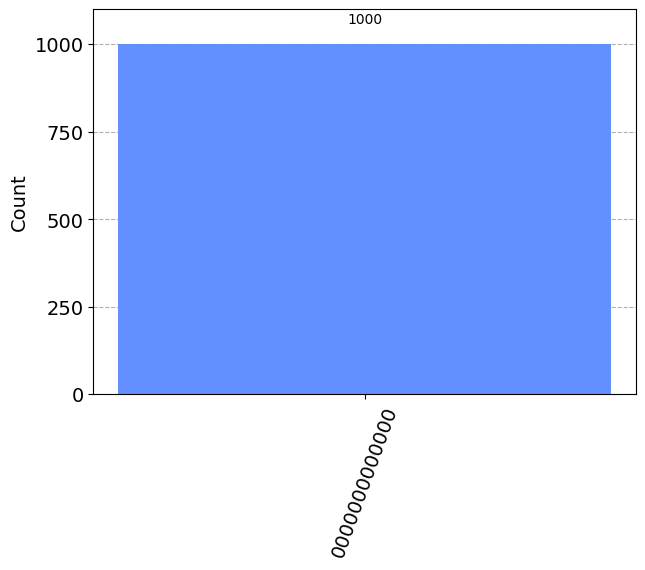

In [8]:
backend = BasicAer.get_backend('qasm_simulator')
shots = 1000
job = execute(djCircuit, backend=backend, shots=shots)
results = job.result() 
answer = results.get_counts()

plot_histogram(answer)